In [40]:
import pandas as pd
import numpy as np 

import os 

import matplotlib.pyplot as plt
import seaborn as sns

### Загрузка датасета

In [2]:
df_path  = './KETI/'

all_dfs = {}
for room in os.listdir(df_path):
    all_dfs[room] = {}
    all_dfs[room]['co2']            = pd.read_csv(f"{df_path}/{room}/co2.csv", names=['UnixTime', 'Value'])
    all_dfs[room]['humidity']       = pd.read_csv(f"{df_path}/{room}/humidity.csv", names=['UnixTime', 'Value'])
    all_dfs[room]['light']          = pd.read_csv(f"{df_path}/{room}/light.csv", names=['UnixTime', 'Value'])
    all_dfs[room]['pir']            = pd.read_csv(f"{df_path}/{room}/pir.csv", names=['UnixTime', 'Value'])
    all_dfs[room]['temperature']    = pd.read_csv(f"{df_path}/{room}/temperature.csv", names=['UnixTime', 'Value'])


In [3]:
# Выделим время начала отчёта каждого ряда
first_tss = [ts['UnixTime'].iloc[0] for room_values in all_dfs.values() for ts in room_values.values()]
last_tss = [ts['UnixTime'].iloc[-1] for room_values in all_dfs.values() for ts in room_values.values()]

Медиана начала: 1377299103.0
Медиана окончания: 1377973409.0


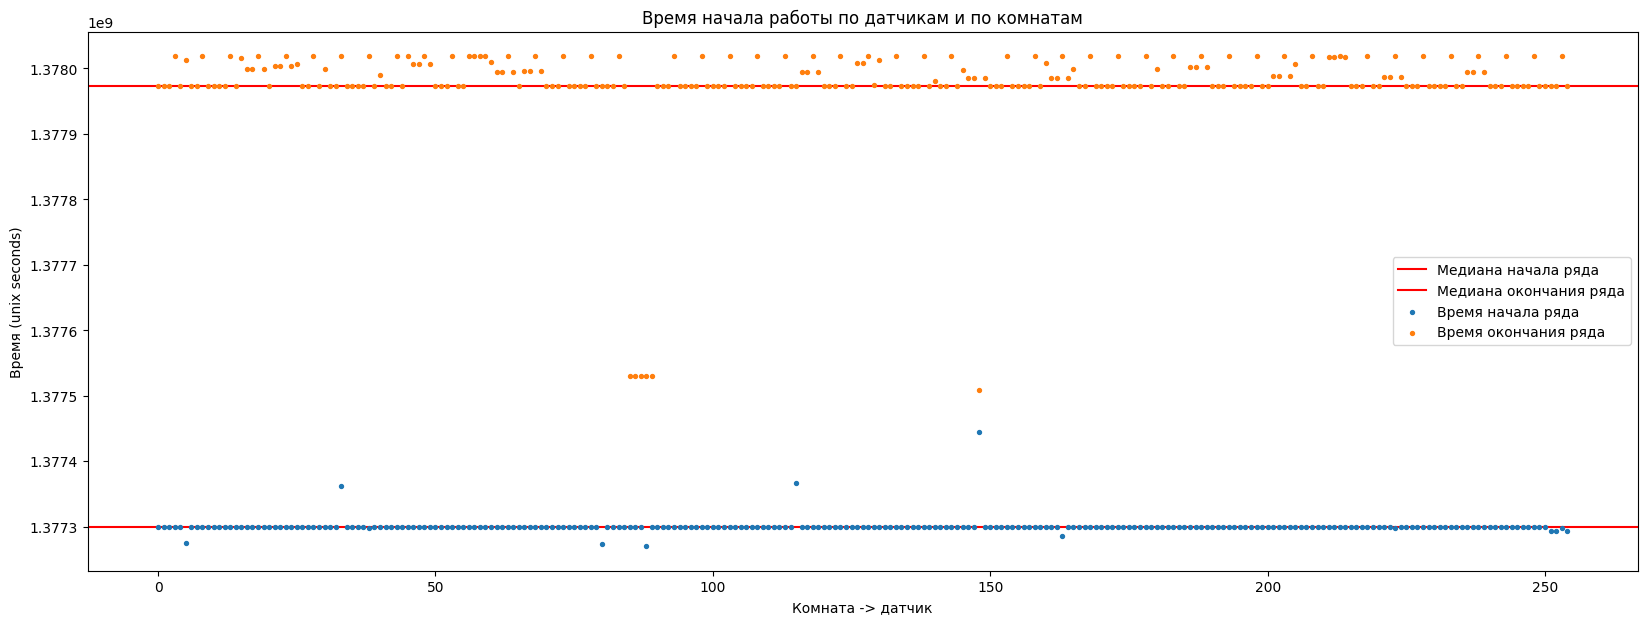

In [4]:
ts_median_first = np.median(first_tss)
ts_median_last = np.median(last_tss)

print(f"Медиана начала: {ts_median_first}")
print(f"Медиана окончания: {ts_median_last}")

plt.figure(figsize=(20, 7))
plt.axhline(y=ts_median_first, c='r', zorder=0, label='Медиана начала ряда')
plt.axhline(y=ts_median_last, c='r', zorder=0, label='Медиана окончания ряда')
plt.scatter(x=[i for i in range(len(first_tss))], y=first_tss, s=8, zorder=1, label="Время начала ряда")
plt.scatter(x=[i for i in range(len(last_tss))], y=last_tss, s=8, zorder=1, label="Время окончания ряда")
plt.title("Время начала работы по датчикам и по комнатам")
plt.xlabel("Комната -> датчик")
plt.ylabel("Время (unix seconds)")

plt.legend()
plt.show()

Как видно, некоторые ряды выбиваются из общих рамок. Это будет мешать соединить ряды воедино. <br>
Уберём данные комнат, в которых значения начала или конца ряда сильно отбиваются от медианных.

In [5]:
# Для начала обрежем значения рядов, выходящих за рамки
cut_offset = 500
filtered_dfs_1 = {}

for room_name, room_dfs in all_dfs.items():
    filtered_dfs_1[room_name] = {}
    for df_name, df in room_dfs.items():
        filtered_dfs_1[room_name][df_name] = df[(df['UnixTime'] >= ts_median_first + cut_offset) & (df['UnixTime'] <= ts_median_last - cut_offset)]

In [6]:
time_offset = 120
filtered_dfs = {}

for room_name, room_dfs in filtered_dfs_1.items():
    is_in_range = True
    for df in room_dfs.values():
        if(np.abs(df['UnixTime'].iloc[0] - ts_median_first - cut_offset) > time_offset):
            is_in_range = False
            break
        if(np.abs(df['UnixTime'].iloc[-1] - ts_median_last + cut_offset) > time_offset):
            is_in_range = False
            break
    
    if is_in_range:
        filtered_dfs[room_name] = room_dfs

In [7]:
first_tss_flt = [ts['UnixTime'].iloc[0] for room_values in filtered_dfs.values() for ts in room_values.values()]
last_tss_flt = [ts['UnixTime'].iloc[-1] for room_values in filtered_dfs.values() for ts in room_values.values()]

Медиана начала: 1377299605.0
Медиана окончания: 1377972907.0


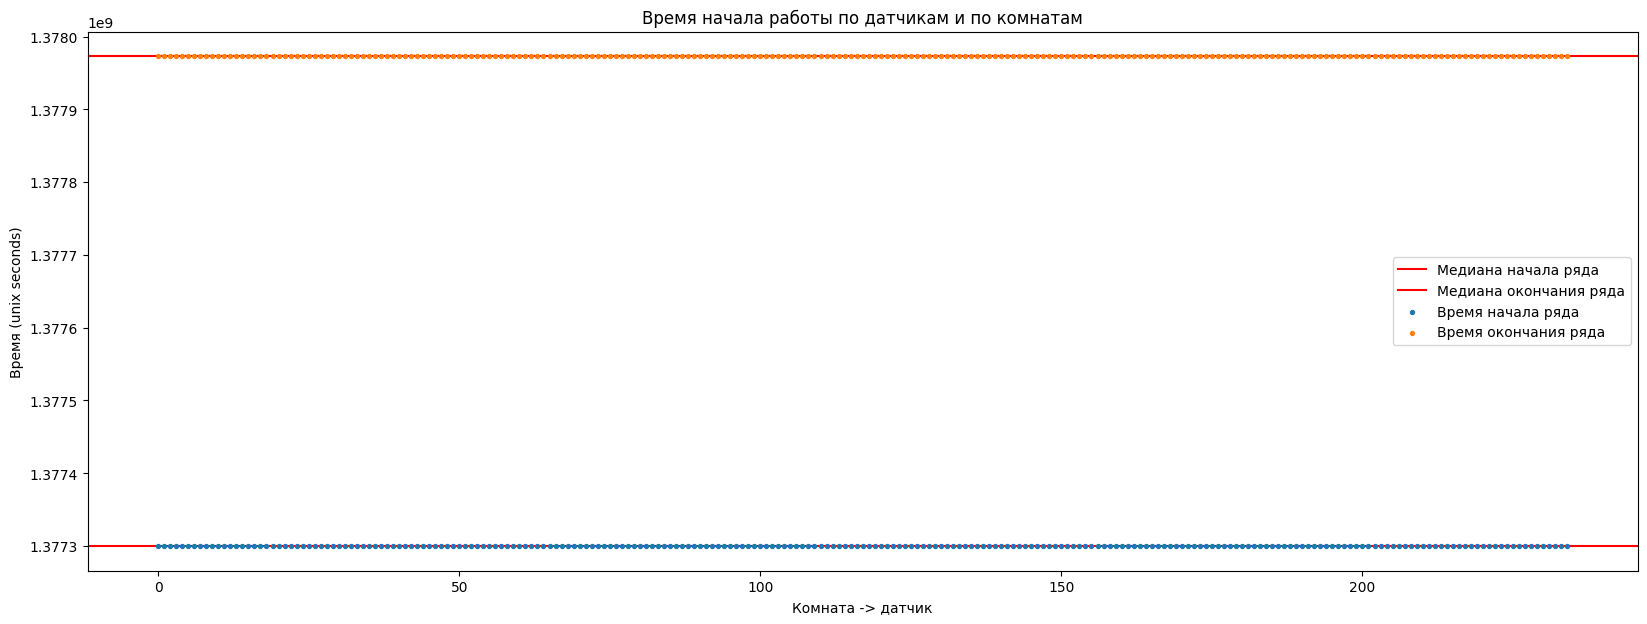

In [8]:
ts_median_first_flt = np.median(first_tss_flt)
ts_median_last_flt = np.median(last_tss_flt)

print(f"Медиана начала: {ts_median_first_flt}")
print(f"Медиана окончания: {ts_median_last_flt}")

plt.figure(figsize=(20, 7))
plt.axhline(y=ts_median_first_flt, c='r', zorder=0, label='Медиана начала ряда')
plt.axhline(y=ts_median_last_flt, c='r', zorder=0, label='Медиана окончания ряда')
plt.scatter(x=[i for i in range(len(first_tss_flt))], y=first_tss_flt, s=8, zorder=1, label="Время начала ряда")
plt.scatter(x=[i for i in range(len(last_tss_flt))], y=last_tss_flt, s=8, zorder=1, label="Время окончания ряда")
plt.title("Время начала работы по датчикам и по комнатам")
plt.xlabel("Комната -> датчик")
plt.ylabel("Время (unix seconds)")

plt.legend()
plt.show()

Теперь мы имеем данные, время начала и окончания которых ПРИМЕРНО одинаковы

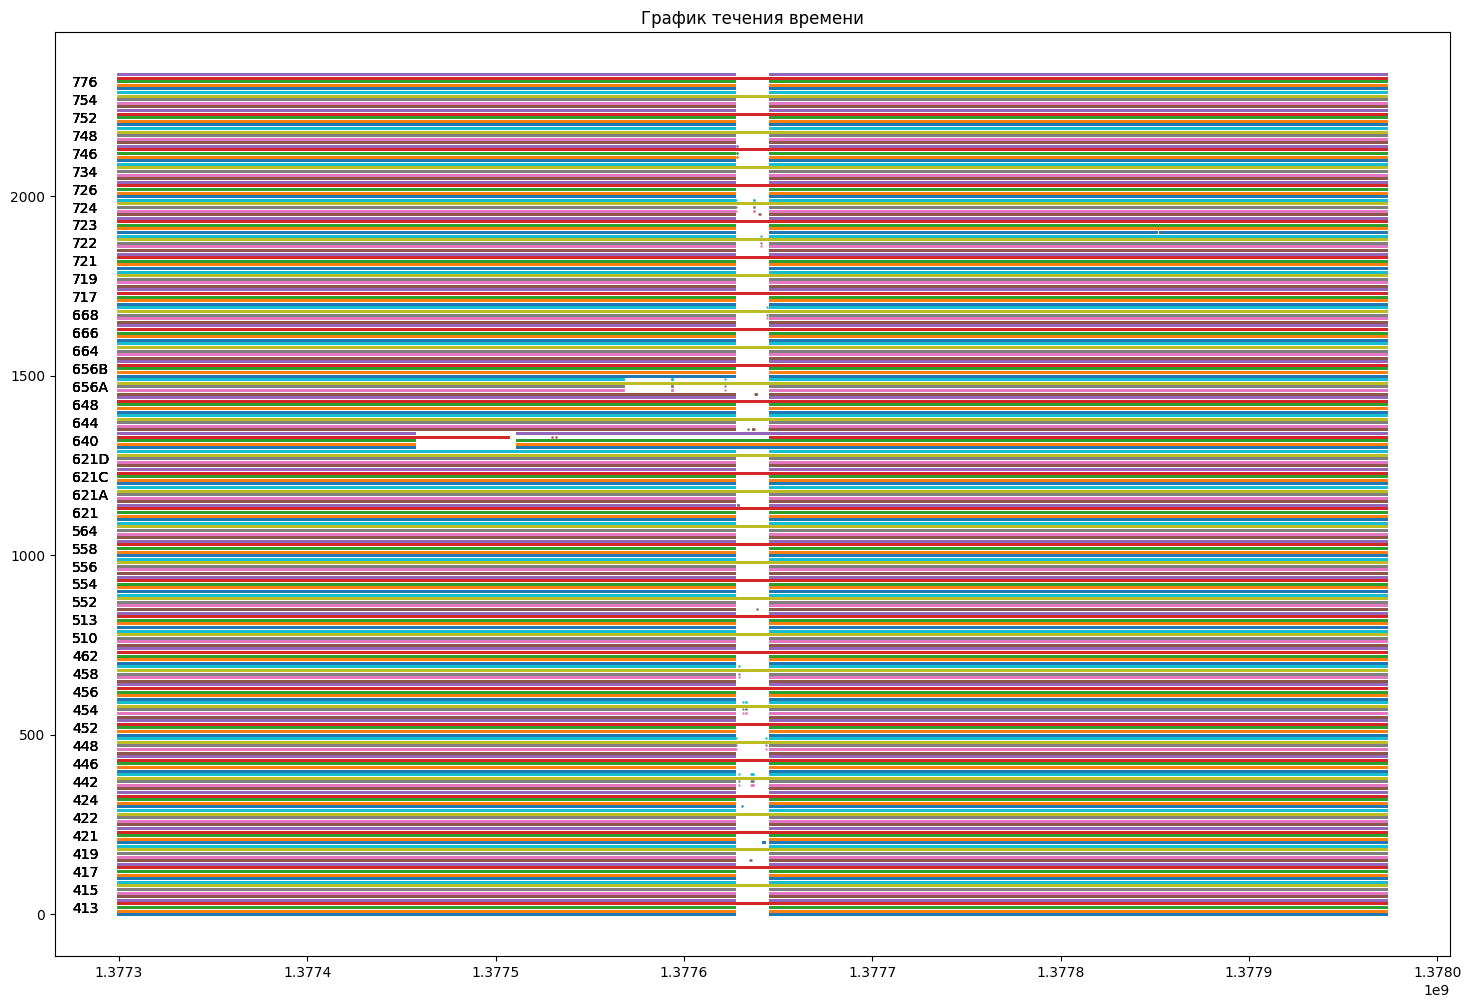

In [9]:
# Посмотрим на заполненность временной шкалы

plt.figure(figsize=(18, 12))

for i, (room_name, room_dfs) in enumerate(filtered_dfs.items()):
    for j, (df_name, df) in enumerate(room_dfs.items()):
        plt.text(x=1377275000, y=50*i+5, s=room_name)
        plt.scatter(df['UnixTime'], [i*50 + j*10 for k in range(len(df['UnixTime']))], s=0.5)

plt.title("График течения времени")
plt.show()

Похоже на какое-то время датчики не работали. Причём по большей части в одно и то же время.<br>
Комнаты 640 и 656А уберём, слишком много пробелов. Остальные попытаемся заполнить интерполяцией

In [10]:
del filtered_dfs['640']
del filtered_dfs['656A']

In [11]:
# Сдвинем начала рядов к среднему значению, чтобы компенсировать рассинхронность такта отчёта датчиков

first_mean_tss = int(np.mean(first_tss_flt))
for room_dfs in filtered_dfs.values():
    for df in room_dfs.values():
        offset = df['UnixTime'].iloc[0] - first_mean_tss
        df['TimeIndex'] = pd.to_datetime(df['UnixTime'] - offset, unit='s')

In [161]:
# Пересобираем индекс, чтобы разница во времени показаний была ровно 5 сек
# Недостающие значения заполняем с помощью интерполяции
# ToDo: посмотреть как это повлияет на значение таргета

data = pd.DataFrame()
butch_len = 0

for room_name, room_dfs in filtered_dfs.items():
    tmp_df = pd.DataFrame()
    for df_name, df in room_dfs.items():
        new_df = df.resample('5s', on='TimeIndex').mean().interpolate(method='linear').drop('UnixTime', axis=1).rename(columns={"Value": df_name})
        if (tmp_df.columns.size == 0):
            tmp_df = new_df
        else:
            tmp_df = tmp_df.join(new_df, how='outer')

    tmp_df['room'] = room_name

    if (data.columns.size == 0):
        data = tmp_df
        butch_len = len(tmp_df.index.values)
    else:
        data = pd.concat([data, tmp_df.iloc[:butch_len, :]], axis=0)

In [162]:
data

,co2,humidity,light,pir,temperature,room
TimeIndex,,,,,,
2013-08-23 23:13:25,511.0,45.31,98.0,0.0,23.98,413
2013-08-23 23:13:30,510.0,45.31,99.0,0.0,23.99,413
2013-08-23 23:13:35,511.0,45.31,99.0,0.0,23.98,413
2013-08-23 23:13:40,512.0,45.31,99.0,0.0,23.98,413
2013-08-23 23:13:45,511.0,45.28,99.0,0.0,23.99,413
...,...,...,...,...,...,...
2013-08-31 18:14:45,513.0,54.32,69.0,0.0,24.32,776
2013-08-31 18:14:50,504.0,54.32,69.0,0.0,24.32,776
2013-08-31 18:14:55,514.0,54.36,69.0,0.0,24.32,776


In [163]:
data.index.isnull().sum()

0

In [164]:
data.isnull().sum()

co2             1
humidity        2
light           2
pir            47
temperature     2
room            0
dtype: int64

In [165]:
data = data.interpolate(method='linear')

In [166]:
data.isnull().sum()

co2            0
humidity       0
light          0
pir            0
temperature    0
room           0
dtype: int64

In [167]:
data[data['room'] == '415']

,co2,humidity,light,pir,temperature,room
TimeIndex,,,,,,
2013-08-23 23:13:25,521.0,51.79,69.0,0.0,23.34,415
2013-08-23 23:13:30,521.0,51.79,65.0,0.0,23.34,415
2013-08-23 23:13:35,525.0,51.79,70.0,0.0,23.34,415
2013-08-23 23:13:40,518.0,51.79,70.0,0.0,23.34,415
2013-08-23 23:13:45,509.0,51.79,69.0,0.0,23.33,415
...,...,...,...,...,...,...
2013-08-31 18:14:45,487.0,58.79,49.0,0.0,22.38,415
2013-08-31 18:14:50,487.0,58.76,48.0,0.0,22.39,415
2013-08-31 18:14:55,475.0,58.76,49.0,0.0,22.39,415


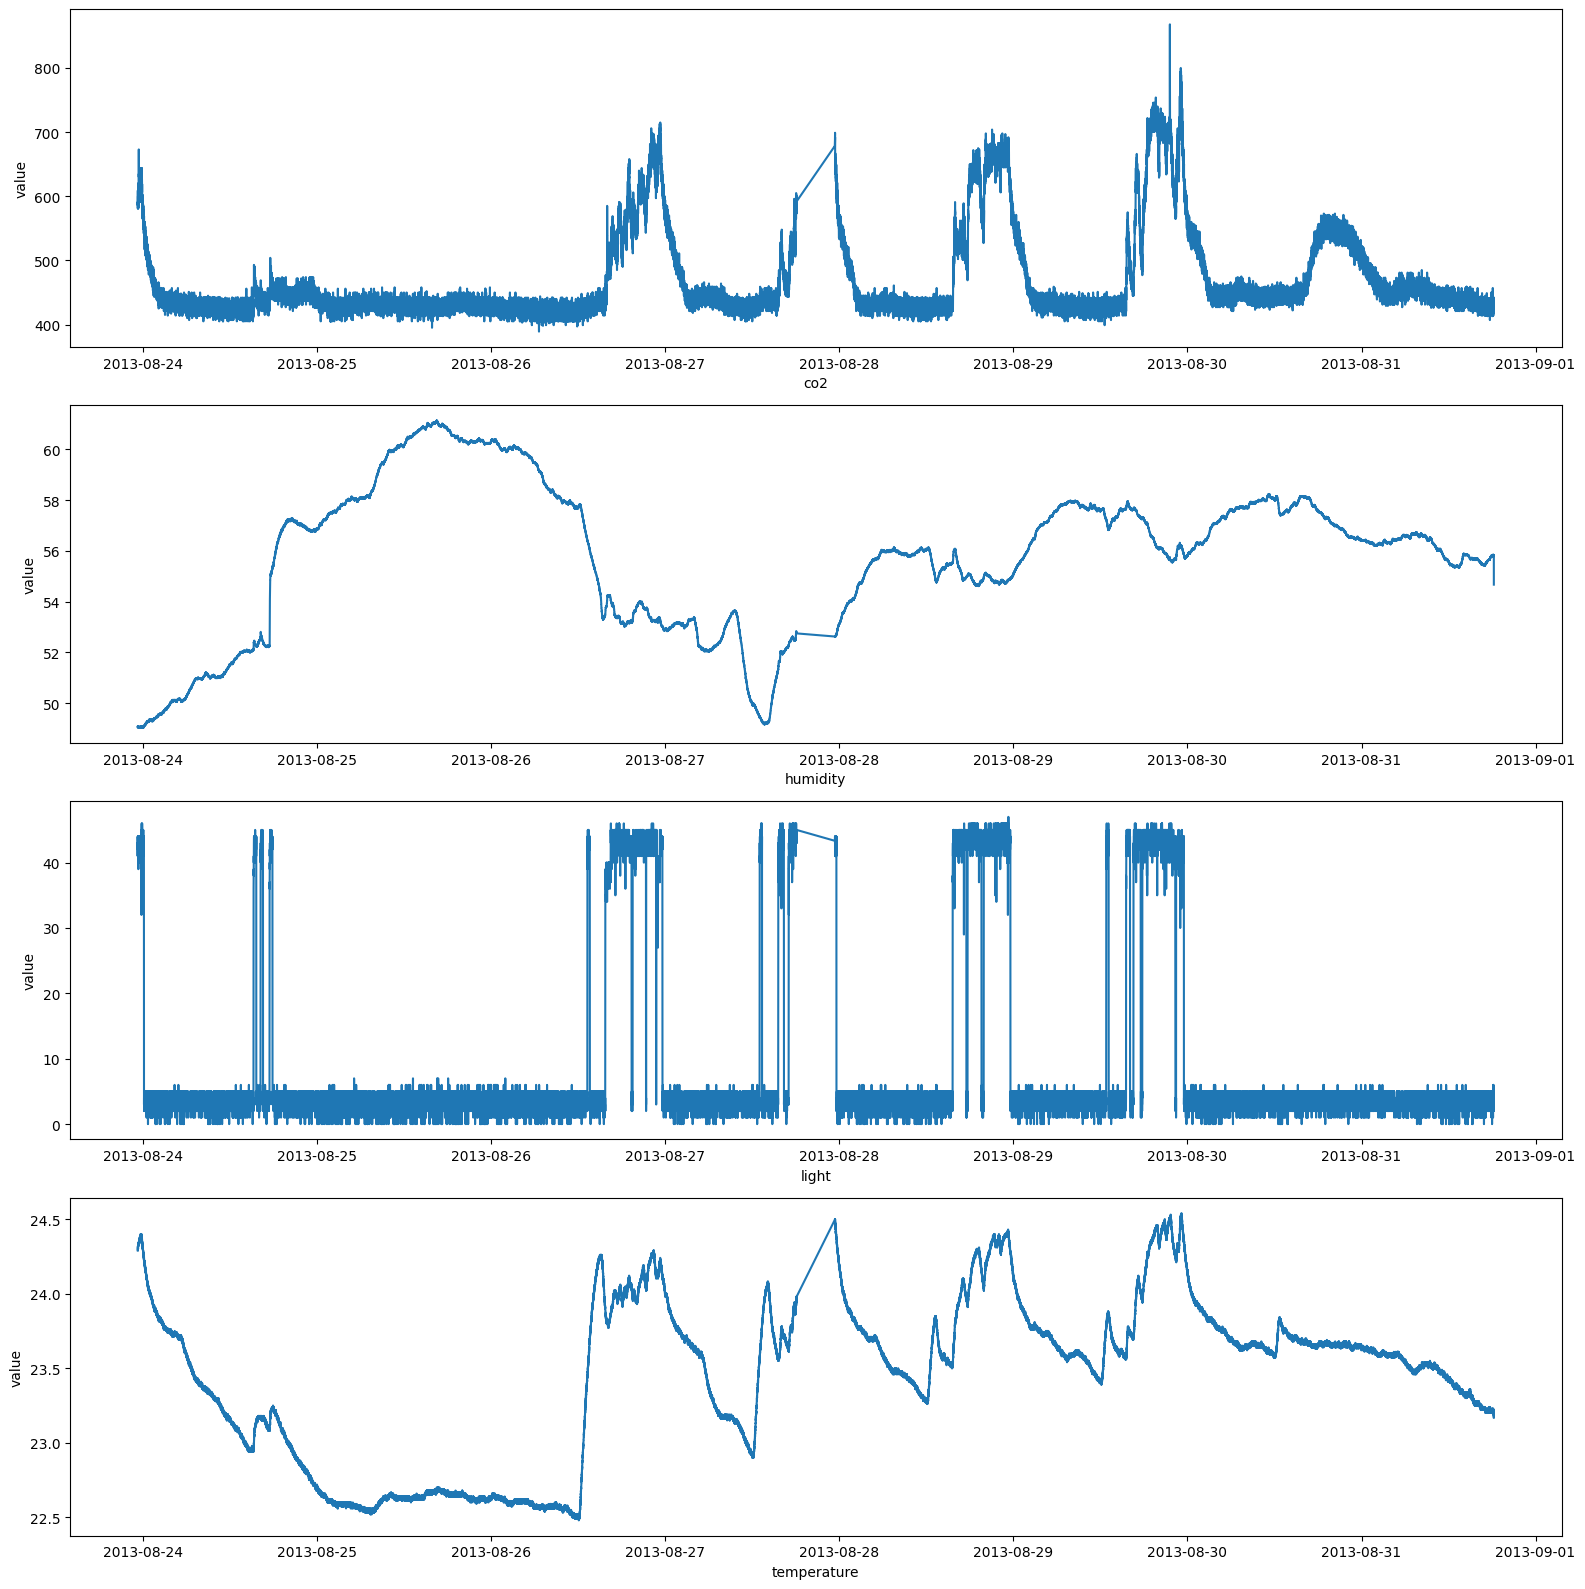

In [168]:
fig, axs = plt.subplots(4, 1, figsize=(16, 16))

df_test = data[data['room'] == '556'][['co2', 'humidity', 'light', 'temperature']]

for i, col in enumerate(df_test.columns):
    sns.lineplot(data=df_test, x='TimeIndex', y=col, ax=axs[i])
    axs[i].set_xlabel(col)
    axs[i].set_ylabel('value')
    
plt.tight_layout()
plt.show()

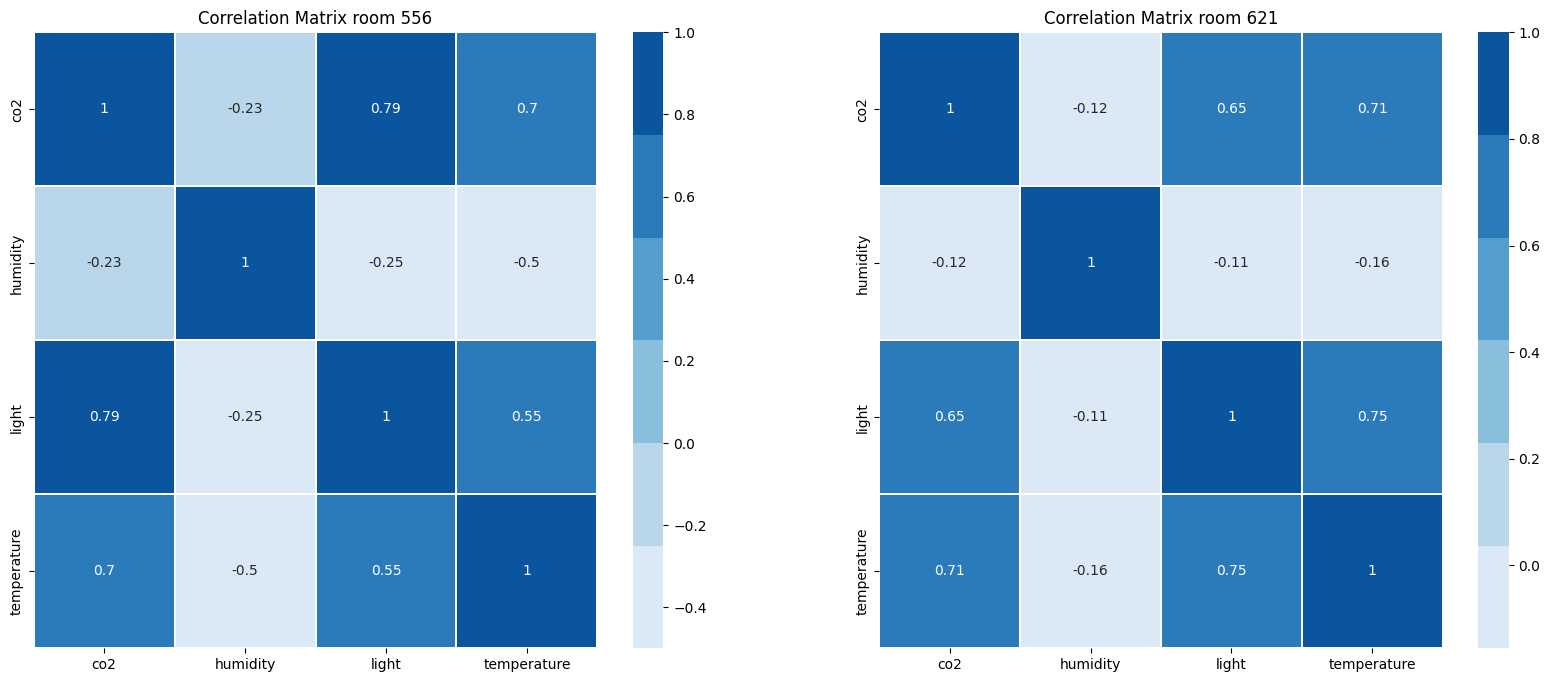

In [169]:
corr1 = df_test.corr()
corr2 = data[data['room'] == '621'][['co2', 'humidity', 'light', 'temperature']].corr()

fix, axs = plt.subplots(1, 2, figsize=(20, 8))
sns.heatmap(corr1, cmap=sns.color_palette('Blues'), linewidths=0.1, linecolor='white', annot=True, ax=axs[0])
axs[0].set_title('Correlation Matrix room 556')

sns.heatmap(corr2, cmap=sns.color_palette('Blues'), linewidths=0.1, linecolor='white', annot=True, ax=axs[1])
axs[1].set_title('Correlation Matrix room 621')
plt.show()

In [185]:
data.sort_index(inplace=True)

In [ ]:
data.to_csv('clean_data.csv')

***

### Подготовка данных для нейронки

In [3]:
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

In [4]:
df = pd.read_csv('./clean_data.csv', index_col=0)

In [5]:
df

,co2,humidity,light,pir,temperature,room
TimeIndex,,,,,,
2013-08-23 23:13:25,511.0,45.31,98.0,0.0,23.98,413
2013-08-23 23:13:25,454.0,51.67,359.0,0.0,23.42,719
2013-08-23 23:13:25,506.0,48.94,5.0,0.0,24.11,442
2013-08-23 23:13:25,457.0,48.16,4.0,0.0,24.54,726
2013-08-23 23:13:25,425.0,51.28,5.0,0.0,23.56,448
...,...,...,...,...,...,...
2013-08-31 18:15:05,298.0,59.34,161.0,0.0,21.38,721
2013-08-31 18:15:05,316.0,58.64,2363.0,0.0,22.86,668
2013-08-31 18:15:05,356.0,52.18,2.0,0.0,22.69,452


Будем предсказывать уровень углекислого газа в комнате (co2)

In [6]:
room = '556'
df = df[df['room'] == room].iloc[:50000]

In [7]:
# Скейлим значения от 0 до 1
scalerX = MinMaxScaler(feature_range=(0,1))
scalerY = MinMaxScaler(feature_range=(0,1))

X = scalerX.fit_transform(df[['co2', 'light', 'humidity', 'temperature']])
scalerY.fit_transform(df[['co2']])

array([[0.70422535],
       [0.74295775],
       [0.70422535],
       ...,
       [0.75352113],
       [0.78521127],
       [0.81690141]])

In [8]:
# делим на train/test
train_split = 0.9
val_split = 0.95
train_split_n = int(len(df) * train_split)
val_split_n = int(len(df) * val_split)

train       = X[:train_split_n, :]
validation  = X[train_split_n:val_split_n, :]
test        = X[val_split_n:, :]

In [9]:
print("Train len:", len(train))
print("Validation len:", len(validation))
print("Test len:", len(test))

Train len: 45000
Validation len: 2500
Test len: 2500


In [10]:
# Целефой признак должен быть первым стольбиком
def single_step_sampler(data_array, lags=1):
    dataX = []
    dataY = []
    for i in range(lags, len(data_array)):
        dataX.append(data_array[i - lags:i])
        dataY.append(data_array[i, 0])
    return np.asarray(dataX, np.float64), np.asarray(dataY, np.float64)

In [29]:
n_past = 60

trainX, trainY = single_step_sampler(train, lags=n_past)
validationX, validationY = single_step_sampler(validation, lags=n_past)
testX, testY = single_step_sampler(test, lags=n_past)

In [30]:
n_train_features = len(trainX[0][0])
print("Количество входных колонок:", n_train_features)

Количество входных колонок: 4


***

### Модель

In [13]:
import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense, Dropout

from tensorflow.keras.optimizers import Adam, Adadelta, RMSprop, Adagrad
from tensorflow.keras.models import load_model
from tensorflow.keras.metrics import MeanAbsolutePercentageError

from scikeras.wrappers import KerasRegressor
from sklearn.model_selection import GridSearchCV

In [14]:
def R2Score(y, y_pred):
  residual = tf.reduce_sum(tf.square(tf.subtract(y, y_pred)))
  total = tf.reduce_sum(tf.square(tf.subtract(y, tf.reduce_mean(y))))
  r2 = tf.subtract(1.0, tf.compat.v1.div(residual, total))
  return r2

In [44]:
model = Sequential()

model.add(LSTM(256 + n_past, return_sequences=True, input_shape=(n_past, n_train_features)))
model.add(LSTM(256 + n_past))
model.add(Dropout(0.2))
model.add(Dense(1))

model.compile(loss='mse', 
              optimizer = Adam(learning_rate=1e-3),
              metrics=[R2Score, MeanAbsolutePercentageError()])

In [45]:
physical_devices = tf.config.list_physical_devices('GPU')
if(physical_devices):
    detales = tf.config.experimental.get_device_details(physical_devices[0])
    print(f"Код GPU: {physical_devices[0].name}")
    print(f"Имя GPU: {detales['device_name']}")

Код GPU: /physical_device:GPU:0
Имя GPU: NVIDIA GeForce RTX 3050 Laptop GPU


In [46]:
num_epochs= 20

with tf.device("gpu:0"):
    model.fit(trainX, 
              trainY, 
              epochs=num_epochs, 
              batch_size=128,
              validation_data=(validationX, validationY))

Epoch 1/20


352/352 [==============================] - 16s 38ms/step - loss: 0.0018 - R2Score: 0.7468 - mean_absolute_percentage_error: 3159.0439 - val_loss: 0.0010 - val_R2Score: -1.0186 - val_mean_absolute_percentage_error: 10.1460
Epoch 2/20
352/352 [==============================] - 12s 34ms/step - loss: 6.1663e-04 - R2Score: 0.8907 - mean_absolute_percentage_error: 2207.4231 - val_loss: 0.0014 - val_R2Score: -1.7539 - val_mean_absolute_percentage_error: 12.1794
Epoch 3/20
352/352 [==============================] - 12s 34ms/step - loss: 5.2070e-04 - R2Score: 0.9101 - mean_absolute_percentage_error: 1939.6866 - val_loss: 8.9177e-04 - val_R2Score: -0.6340 - val_mean_absolute_percentage_error: 10.0329
Epoch 4/20
352/352 [==============================] - 12s 35ms/step - loss: 4.4728e-04 - R2Score: 0.9220 - mean_absolute_percentage_error: 1805.8389 - val_loss: 4.8728e-04 - val_R2Score: 0.3571 - val_mean_absolute_percentage_error: 8.0378
Epoch 5/20
352/352 [==============================] - 12s 34m

In [21]:
model.save('./best_model.keras')

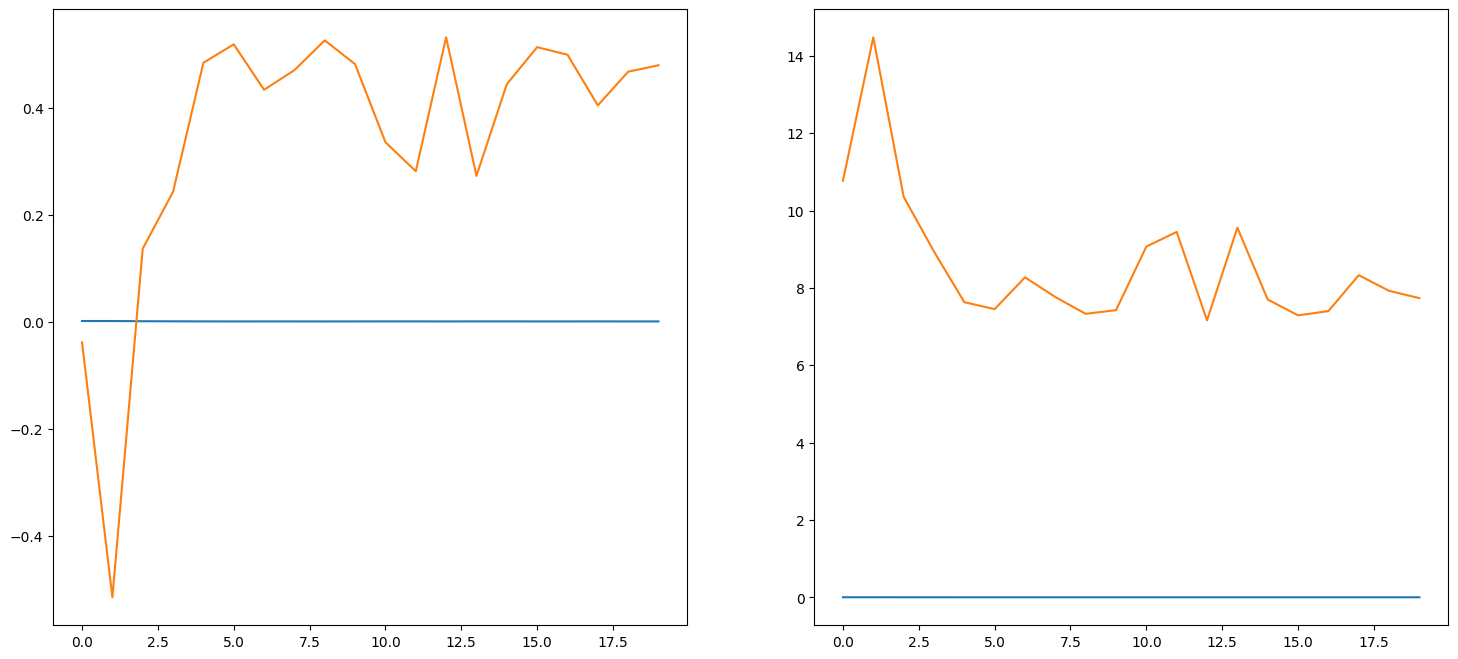

In [22]:
fig, axs = plt.subplots(1, 2, figsize=(18, 8))

axs[0].plot(model.history.history['val_loss'])
axs[0].plot(model.history.history['val_R2Score'])

axs[1].plot(model.history.history['val_loss'])
axs[1].plot(model.history.history['val_mean_absolute_percentage_error'])

***

### Предсказание

In [23]:
m = load_model("./best_model.keras", custom_objects={'R2Score': R2Score})

In [24]:
prediction_scaled = m.predict(testX)

75/75 [==============================] - 2s 19ms/step


In [25]:
prediction = scalerY.inverse_transform(prediction_scaled.reshape(-1, 1)).reshape(1, -1)[0]
prediction

array([504.91772, 507.75458, 512.59235, ..., 607.7224 , 607.1077 ,
       612.1167 ], dtype=float32)

In [26]:
original_copies_array = scalerY.inverse_transform(testY.reshape(-1, 1)).reshape(1, -1)[0]
original_copies_array

array([508., 512., 520., ..., 603., 612., 621.])

In [27]:
print("R2 на тестовой выборке:", R2Score(testY, prediction).numpy())

R2 на тестовой выборке: -23144110.750903223


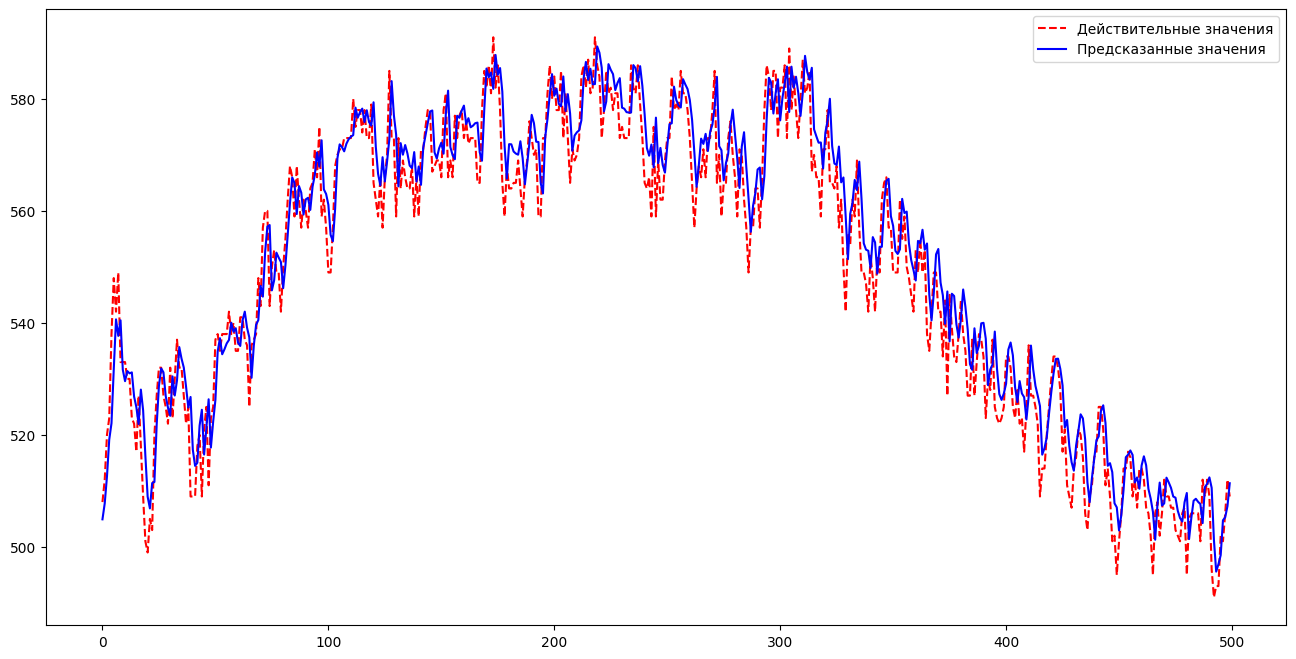

In [28]:
plt.figure(figsize=(16, 8))

time_index = df.index[val_split_n+n_past:].values
num_observe = 500

plt.plot([i for i in range(num_observe)], original_copies_array[:num_observe], "--", label='Действительные значения', color='r')
plt.plot([i for i in range(num_observe)], prediction[:num_observe], label='Предсказанные значения', color='b')

plt.legend()
plt.show()